# Projecting images to latent space with StyleGAN2.

Reference: https://github.com/woctezuma/stylegan2-projecting-images

## Requirements

### Install ImageMagick

In [0]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

### Switch to Tensorflow 1.x

The default TensorFlow version in Colab switched from  1.x to 2.x on the 27th of March, 2020.

Reference: https://colab.research.google.com/notebooks/tensorflow_version.ipynb

We switch to version 1.x to avoid the following error:
> `ModuleNotFoundError: No module named 'tensorflow.contrib' colab`

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Install StyleGAN2

In [0]:
!rm -rf stylegan2/
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.


In [0]:
%cd stylegan2/

/content/stylegan2


In [0]:
!nvcc test_nvcc.cu -o test_nvcc -run

CPU says hello.
GPU says hello.


### Mounting Google Drive

In [0]:
!pip install Google-Colab-Transfer

In [0]:
import colab_transfer

In [0]:
colab_transfer.mount_google_drive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Data

### Download a target image

In [0]:
!curl -O https://raw.githubusercontent.com/wiki/woctezuma/stylegan2-projecting-images/img/emmanuel-macron.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77364  100 77364    0     0   191k      0 --:--:-- --:--:-- --:--:--  191k


### Function to display images

In [0]:
from IPython.display import Image, display

def display_image_from_file(image_name):
  image_content = Image(image_name)

  display(image_content)

  return

In [0]:
import PIL.Image

def display_image_from_array(array):
  # Reference: https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629

  image_content = PIL.Image.fromarray(array)

  display(image_content) 

  return  

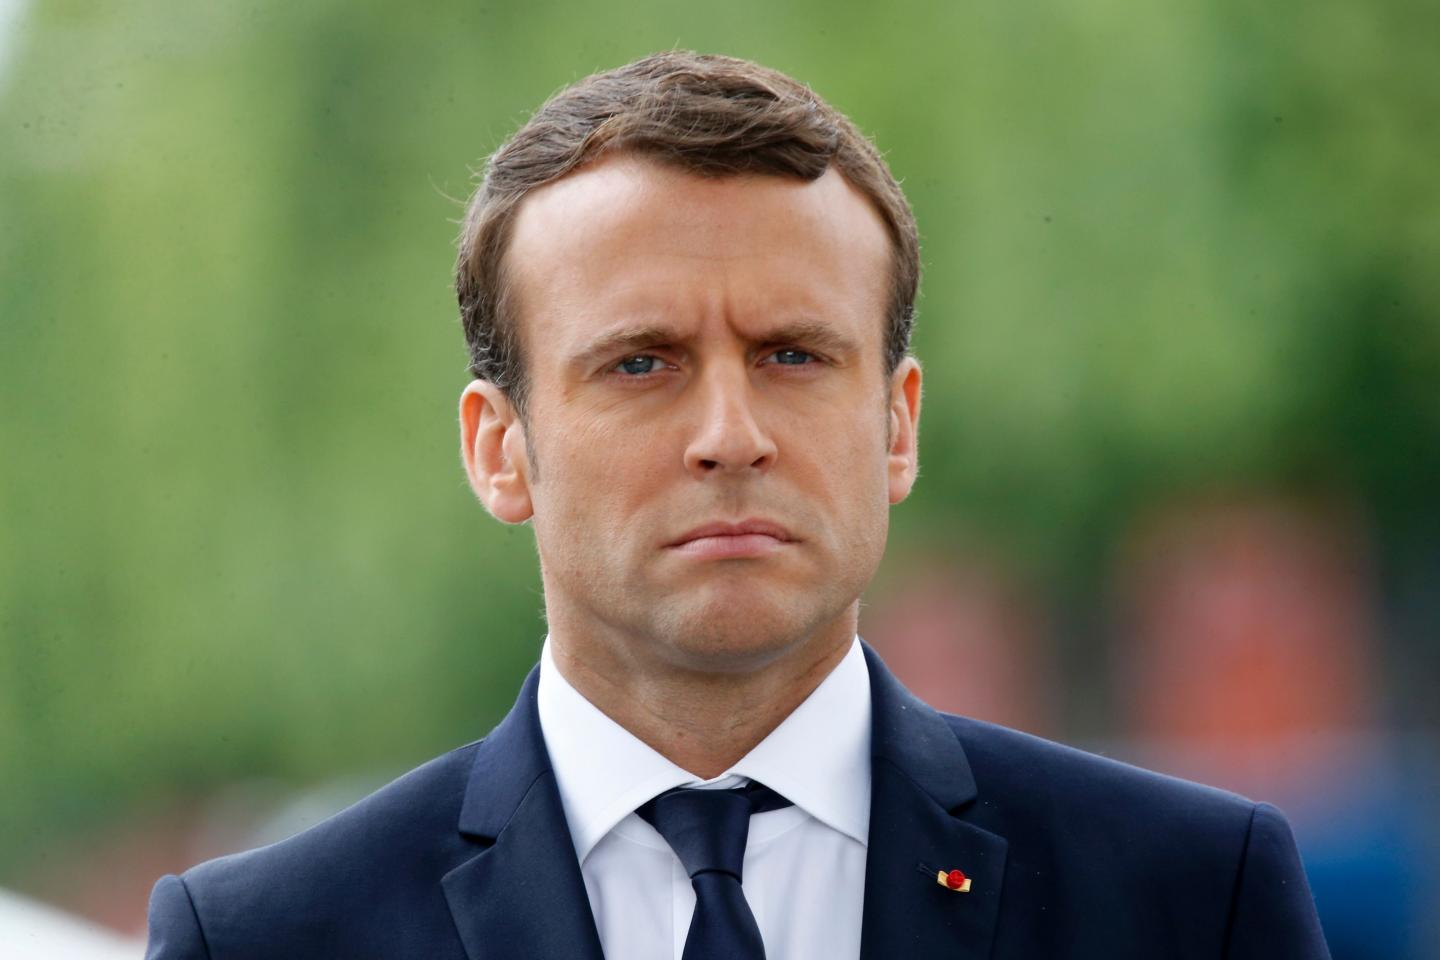

In [0]:
original_image_name = 'emmanuel-macron.jpg'

display_image_from_file(original_image_name)

### Pre-processing: center-crop the target image to 1024x1024

In [0]:
# References:
# [1] https://gist.github.com/dylanvee/3419976
# [2] http://www.imagemagick.org/Usage/thumbnails/#cut
!convert -gravity center -resize 1024x1024^ -extent 1024x1024 emmanuel-macron.jpg emmanuel-macron-crop.jpg

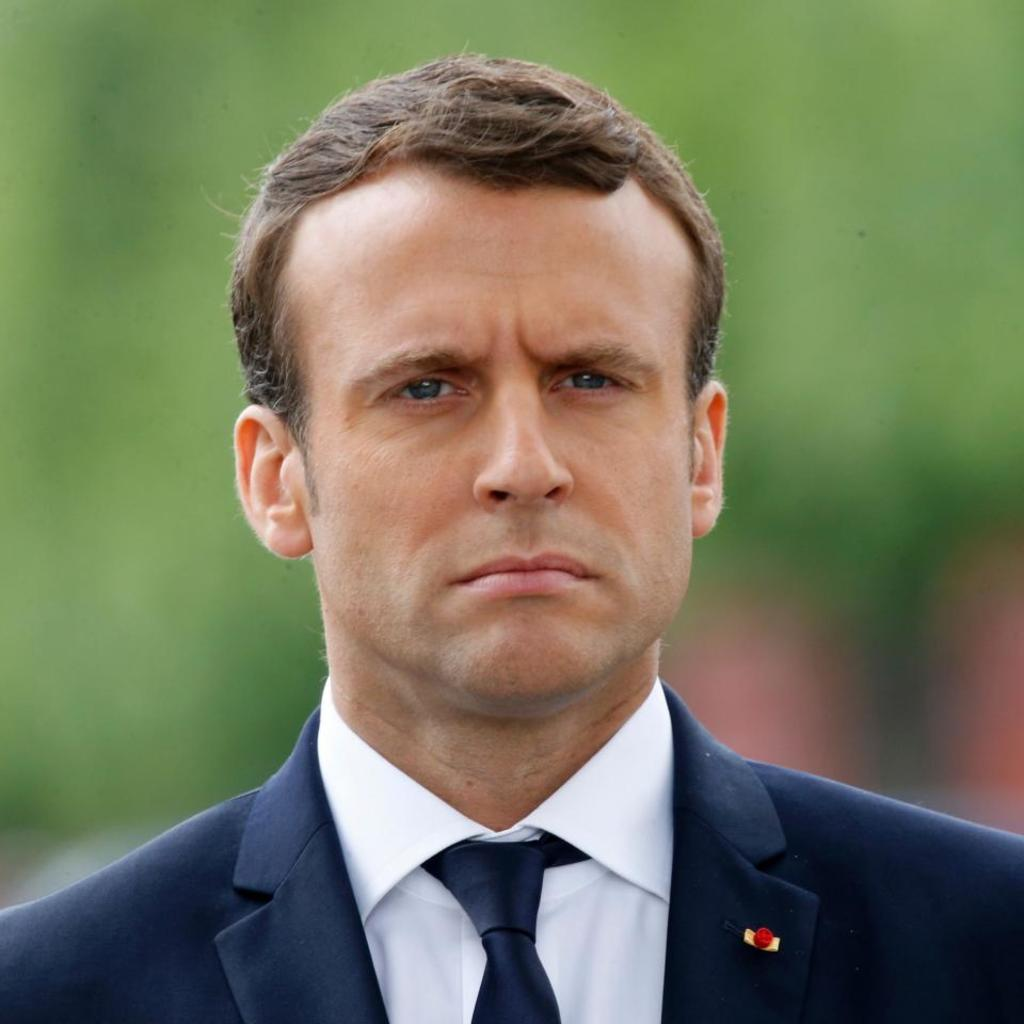

In [0]:
preprocessed_target_image_name = 'emmanuel-macron-crop.jpg'

display_image_from_file(preprocessed_target_image_name)

### Alternative pre-processing: align the target image with 68 face landmarks

Reference: https://github.com/NVlabs/ffhq-dataset

#### Download the trained shape predictor model from dlib

In [0]:
# !curl -O http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [0]:
colab_transfer.copy_file(file_name='shape_predictor_68_face_landmarks.dat.bz2',
                         destination='/content/stylegan2/')

Copying /content/drive/My Drive/shape_predictor_68_face_landmarks.dat.bz2 to /content/stylegan2/shape_predictor_68_face_landmarks.dat.bz2


In [0]:
# Reference: https://superuser.com/a/480951
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

#### Extract 68 face landmarks with dlib

In [0]:
import sys
import os
import dlib
import glob

In [0]:
def detect_face_landmarks(face_file_path=None,
                          predictor_path=None,
                          img=None):
  # References:
  # -   http://dlib.net/face_landmark_detection.py.html
  # -   http://dlib.net/face_alignment.py.html

  if predictor_path is None:
    predictor_path = 'shape_predictor_68_face_landmarks.dat'

  # Load all the models we need: a detector to find the faces, a shape predictor
  # to find face landmarks so we can precisely localize the face
  detector = dlib.get_frontal_face_detector()
  shape_predictor = dlib.shape_predictor(predictor_path)

  if img is None:
    # Load the image using Dlib
    print("Processing file: {}".format(face_file_path))
    img = dlib.load_rgb_image(face_file_path)

  shapes = list()

  # Ask the detector to find the bounding boxes of each face. The 1 in the
  # second argument indicates that we should upsample the image 1 time. This
  # will make everything bigger and allow us to detect more faces.
  dets = detector(img, 1)
    
  num_faces = len(dets)
  print("Number of faces detected: {}".format(num_faces))

  # Find the face landmarks we need to do the alignment.
  faces = dlib.full_object_detections()
  for d in dets:
      print("Left: {} Top: {} Right: {} Bottom: {}".format(
          d.left(), d.top(), d.right(), d.bottom()
      ))

      shape = shape_predictor(img, d)
      faces.append(shape)

  return faces

In [0]:
face_file_path = 'emmanuel-macron.jpg'

faces = detect_face_landmarks(face_file_path=face_file_path)

Processing file: emmanuel-macron.jpg
Number of faces detected: 1
Left: 504 Top: 247 Right: 889 Bottom: 632


#### Align face with dlib's function (out of curiosity)

In [0]:
thumbnail_size = 512

img = dlib.load_rgb_image(face_file_path)

thumbnails = dlib.get_face_chips(img, faces, size=thumbnail_size)

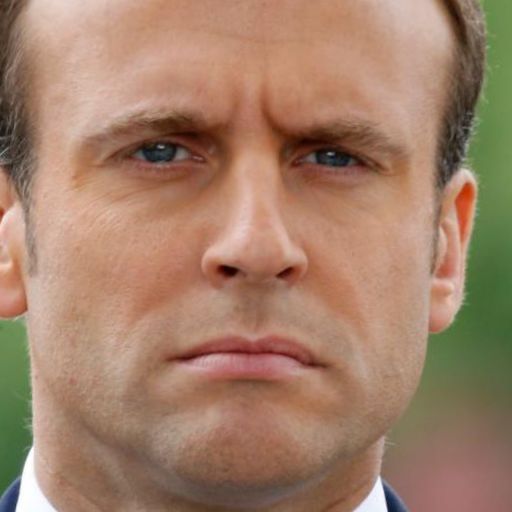

In [0]:
main_face = thumbnails[0]

display_image_from_array(main_face)

#### Align face with FFHQ's methodology (to be used later)

In [0]:
import os
import sys
import requests
import html
import hashlib
import PIL.Image
import PIL.ImageFile
import numpy as np
import scipy.ndimage
import threading
import queue
import time
import json
import uuid
import glob
import argparse
import itertools
import shutil
from collections import OrderedDict, defaultdict

In [0]:
# Reference: https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

def recreate_aligned_images(json_data, 
                            dst_dir='realign1024x1024',
                            output_size=1024, 
                            transform_size=4096, 
                            enable_padding=True):
    print('Recreating aligned images...')
    if dst_dir:
        os.makedirs(dst_dir, exist_ok=True)

    for item_idx, item in enumerate(json_data.values()):
        print('\r%d / %d ... ' % (item_idx, len(json_data)), end='', flush=True)

        # Parse landmarks.
        # pylint: disable=unused-variable
        lm = np.array(item['in_the_wild']['face_landmarks'])
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        print(eye_to_mouth.shape)
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # Load in-the-wild image.
        src_file = item['in_the_wild']['file_path']
        img = PIL.Image.open(src_file)

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]

        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

        # Save aligned image.
        dst_subdir = os.path.join(dst_dir, '%05d' % (item_idx - item_idx % 1000))
        os.makedirs(dst_subdir, exist_ok=True)
        img.save(os.path.join(dst_subdir, '%05d.png' % item_idx))

    # All done.
    print('\r%d / %d ... done' % (len(json_data), len(json_data)))

    return

In [0]:
# The first face which is detected:
# NB: we assume that there is exactly one face per picture!
f = faces[0]

parts = f.parts()

num_face_landmarks=68

v = np.zeros(shape=(num_face_landmarks, 2))
for k, e in enumerate(parts):
  v[k, :] = [e.x, e.y]

In [0]:
json_data = dict()

item_idx = 0

json_data[item_idx] = dict()
json_data[item_idx]['in_the_wild'] = dict()
json_data[item_idx]['in_the_wild']['file_path'] = face_file_path
json_data[item_idx]['in_the_wild']['face_landmarks'] = v

In [0]:
recreate_aligned_images(json_data)

Recreating aligned images...
0 / 1 ... (2,)
1 / 1 ... done


In [0]:
!cp '/content/stylegan2/realign1024x1024/00000/00000.png' emmanuel-macron-aligned.jpg

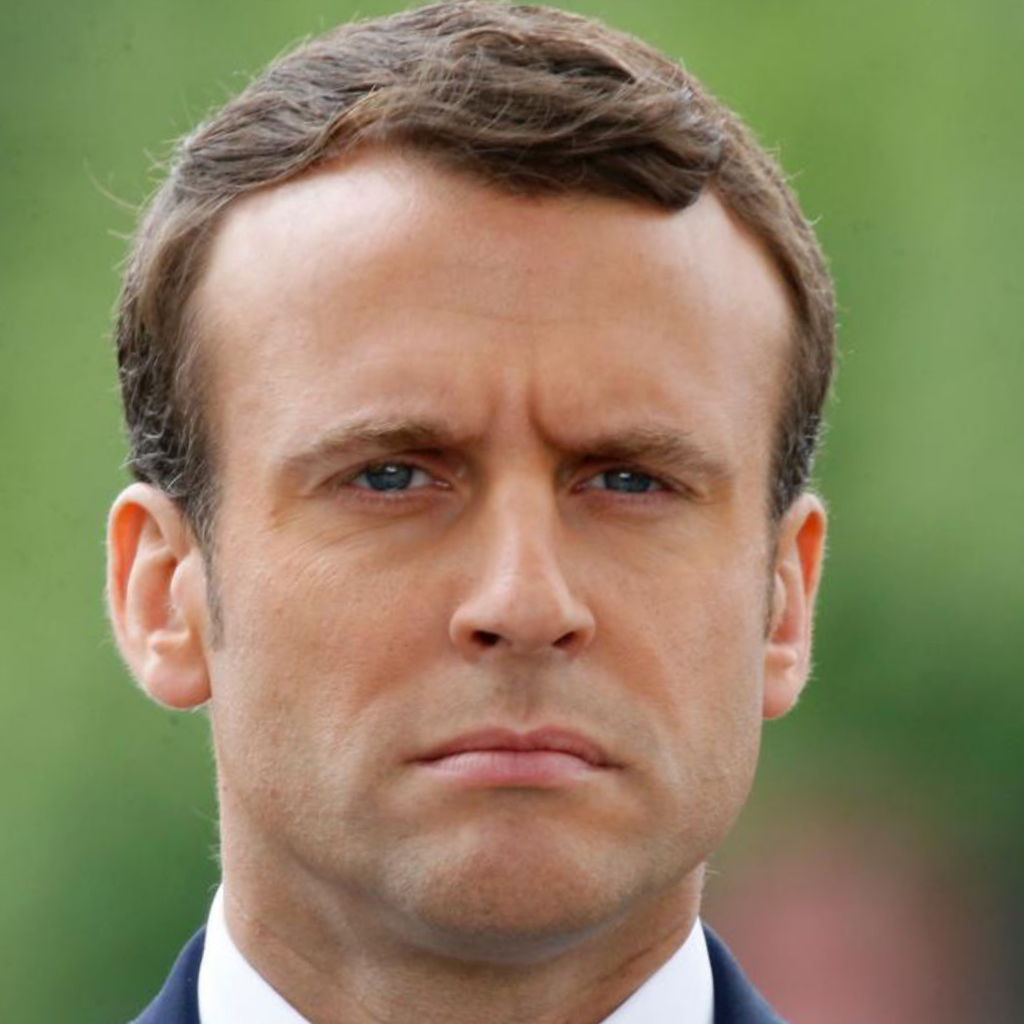

In [0]:
preprocessed_target_image_name = 'emmanuel-macron-aligned.jpg'

display_image_from_file(preprocessed_target_image_name)

### Move the preprocessed target images into the folder expected by StyleGAN2

In [0]:
!mkdir -p /content/img/
!cp emmanuel-macron-crop.jpg /content/img/
!cp emmanuel-macron-aligned.jpg /content/img/

### (optional) Process other possible target images

#### Download

In [0]:
# https://fr.wikipedia.org/wiki/La_Joconde
!curl https://upload.wikimedia.org/wikipedia/commons/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg -o vinci.jpg

# https://fr.wikipedia.org/wiki/Le_Condotti%C3%A8re_(Antonello_de_Messine)
!curl https://upload.wikimedia.org/wikipedia/commons/0/09/Antonello_da_Messina_059.jpg -o messina.jpg

# https://fr.wikipedia.org/wiki/La_Jeune_Fille_%C3%A0_la_perle
!curl https://upload.wikimedia.org/wikipedia/commons/d/d7/Meisje_met_de_parel.jpg -o vermeer.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89.9M  100 89.9M    0     0  25.8M      0  0:00:03  0:00:03 --:--:-- 25.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3776k  100 3776k    0     0  24.5M      0 --:--:-- --:--:-- --:--:-- 24.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6083k  100 6083k    0     0  24.8M      0 --:--:-- --:--:-- --:--:-- 24.8M


#### Pre-process

In [0]:
face_file_path_list = [
                       'emmanuel-macron.jpg',
                       'vinci.jpg',
                       'messina.jpg',
                       'vermeer.jpg',                       
                       ]

In [0]:
num_face_landmarks=68

In [0]:
json_data = dict()

for (item_idx, face_file_path) in enumerate(face_file_path_list): 

  faces = detect_face_landmarks(face_file_path=face_file_path)

  f = faces[0]

  parts = f.parts()

  v = np.zeros(shape=(num_face_landmarks, 2))
  for k, e in enumerate(parts):
    v[k, :] = [e.x, e.y]
    
  json_data[item_idx] = dict()
  json_data[item_idx]['in_the_wild'] = dict()
  json_data[item_idx]['in_the_wild']['file_path'] = face_file_path
  json_data[item_idx]['in_the_wild']['face_landmarks'] = v

Processing file: emmanuel-macron.jpg
Number of faces detected: 1
Left: 504 Top: 247 Right: 889 Bottom: 632
Processing file: vinci.jpg
Number of faces detected: 2
Left: 2386 Top: 1945 Right: 4373 Bottom: 3932
Left: 737 Top: 1774 Right: 773 Bottom: 1810
Processing file: messina.jpg
Number of faces detected: 1
Left: 741 Top: 997 Right: 1891 Bottom: 2147
Processing file: vermeer.jpg
Number of faces detected: 1
Left: 1124 Top: 1636 Right: 2274 Bottom: 2786


In [0]:
recreate_aligned_images(json_data)

In [0]:
!cp '/content/stylegan2/realign1024x1024/00000/00000.png' emmanuel-macron-aligned.jpg
!cp '/content/stylegan2/realign1024x1024/00000/00001.png' vinci-aligned.jpg
!cp '/content/stylegan2/realign1024x1024/00000/00002.png' messina-aligned.jpg
!cp '/content/stylegan2/realign1024x1024/00000/00003.png' vermeer-aligned.jpg

In [0]:
!mkdir -p /content/img/
!cp emmanuel-macron-aligned.jpg /content/img/
!cp vinci-aligned.jpg /content/img/
!cp messina-aligned.jpg /content/img/
!cp vermeer-aligned.jpg /content/img/

#### Out of curiosity, display the 2nd face detected in the Joconde

In [0]:
json_data = dict()

item_idx=0
face_file_path= face_file_path_list[1]

faces = detect_face_landmarks(face_file_path=face_file_path)

f = faces[1] # the second detected face!

parts = f.parts()

v = np.zeros(shape=(num_face_landmarks, 2))
for k, e in enumerate(parts):
  v[k, :] = [e.x, e.y]
  
json_data[item_idx] = dict()
json_data[item_idx]['in_the_wild'] = dict()
json_data[item_idx]['in_the_wild']['file_path'] = face_file_path
json_data[item_idx]['in_the_wild']['face_landmarks'] = v

Processing file: vinci.jpg
Number of faces detected: 2
Left: 2386 Top: 1945 Right: 4373 Bottom: 3932
Left: 737 Top: 1774 Right: 773 Bottom: 1810


In [0]:
recreate_aligned_images(json_data)

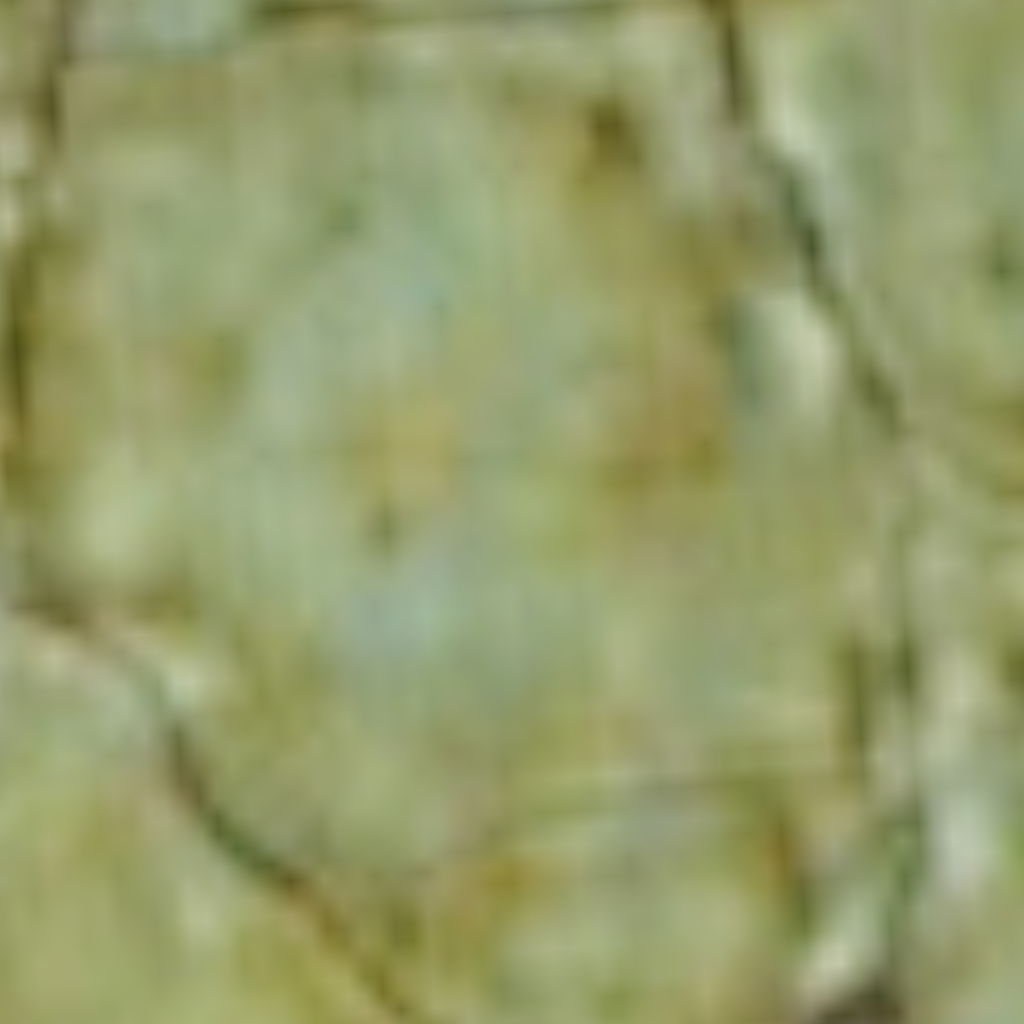

In [0]:
preprocessed_target_image_name = '/content/stylegan2/realign1024x1024/00000/00000.png'

display_image_from_file(preprocessed_target_image_name)

In [0]:
face_file_path = 'joconde.jpg'

img = dlib.load_rgb_image(face_file_path)

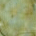

In [0]:
# Processing file: vinci.jpg
# Number of faces detected: 2
# Left: 2386 Top: 1945 Right: 4373 Bottom: 3932
# Left: 737 Top: 1774 Right: 773 Bottom: 1810

# img_crop = img[1945:3932,2386:4373]
img_crop = img[1774:1810,737:773]

display_image_from_array(img_crop)

## StyleGAN2 workflow

### Preparing datasets

In [0]:
!python dataset_tool.py create_from_images '/content/datasets/real' '/content/img'

Loading images from "/content/img"
Creating dataset "/content/datasets/real"
Added 2 images.


### Projecting images to latent space

#### Help

In [0]:
!python run_projector.py project-real-images --help

usage: run_projector.py project-real-images [-h] --network NETWORK_PKL
                                            --data-dir DATA_DIR --dataset
                                            DATASET_NAME
                                            [--num-snapshots NUM_SNAPSHOTS]
                                            [--num-images NUM_IMAGES]
                                            [--result-dir DIR]

optional arguments:
  -h, --help            show this help message and exit
  --network NETWORK_PKL
                        Network pickle filename
  --data-dir DATA_DIR   Dataset root directory
  --dataset DATASET_NAME
                        Training dataset
  --num-snapshots NUM_SNAPSHOTS
                        Number of snapshots (default: 5)
  --num-images NUM_IMAGES
                        Number of images to project (default: 3)
  --result-dir DIR      Root directory for run results (default: results)


#### Run

In [0]:
!python run_projector.py project-real-images \
  --data-dir='/content/datasets' --dataset=real \
  --num-images=2 \
  --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \  
  --num-snapshots=5 \ 


Local submit - run_dir: results/00000-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Loading images from "real"...
tcmalloc: large alloc 4294967296 bytes == 0x59a98000 @  0x7ff1da700001 0x7ff1d8224765 0x7ff1d8288dc0 0x7ff1d828ac5f 0x7ff1d8321238 0x50ac25 0x50d390 0x508245 0x509642 0x595311 0x54a6ff 0x551b81 0x5a067e 0x50d966 0x508245 0x50a080 0x50aa7d 0x50d390 0x508245 0x58958c 0x5a067e 0x50d966 0x509d48 0x50aa7d 0x50c5b9 0x509d48 0x50aa7d 0x50c5b9 0x508245 0x58958c 0x5a067e
tcmalloc: large alloc 4294967296 bytes == 0x7fef91f80000 @  0x7ff1da6fe1e7 0x7ff1d82245e1 0x7ff1d8288e88 0x7ff1d8289147 0x7ff1d8321118 0x50ac25 0x50d390 0x508245 0x50a080 0x50aa7d 0x50d390 0x508245 0x50a080 0x50aa7d 0x

### Displaying the projected images

#### Display utility function

In [0]:
def get_projection_folder_name():
  projection_folder_name = '/content/stylegan2/results/00000-project-real-images/'

  return projection_folder_name

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_projection(image_id_as_int,
                       projection_folder_name=None):
  
  if projection_folder_name is None:
    projection_folder_name = get_projection_folder_name()

  image_id = '{:04d}'.format(image_id_as_int)

  ext = '.png'

  # The first picture is the target, then there are the 4 projections as the number of steps increases.
  num_cols = 7

  # Caveat: if nrows is different from 1, then axs is a list of list of axes, instead of a list of axes. So, you will get errors such as:
  # https://stackoverflow.com/questions/43957776/numpy-ndarray-object-has-no-attribute-imshow
  fig, axs = plt.subplots(nrows=1,
                          ncols=num_cols,
                          figsize=(50,50))  
  
  for i, ax in enumerate(axs):
    if i == 0 or i==6:
      # Target (input)
      f_name = 'image' + image_id + '-target'
    else:
      # Projections
      f_name = 'image' + image_id + '-step{:04d}'.format(200*i)

    image_name = projection_folder_name + f_name + ext
    img = mpimg.imread(image_name)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f_name)  

  plt.show()

  return

#### Display with center-crop

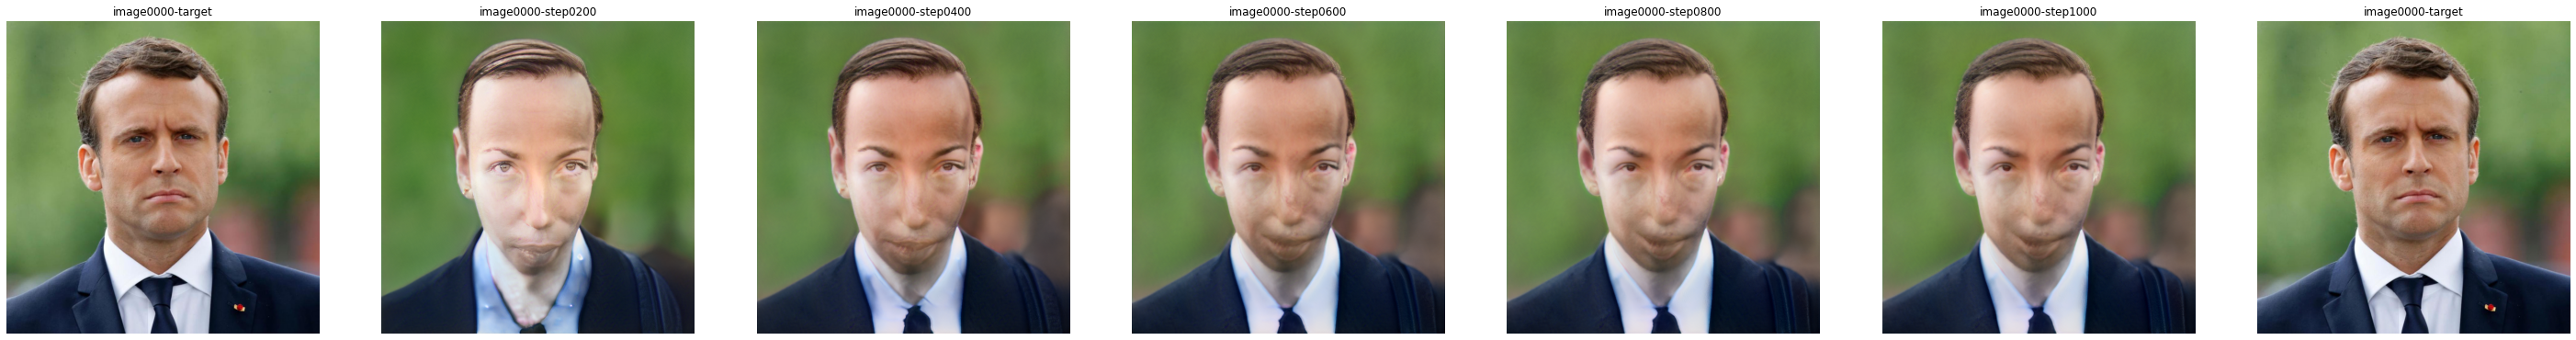

In [0]:
# The id is the first index (zero).
display_projection(image_id_as_int=0)

#### Display with FFHQ alignment

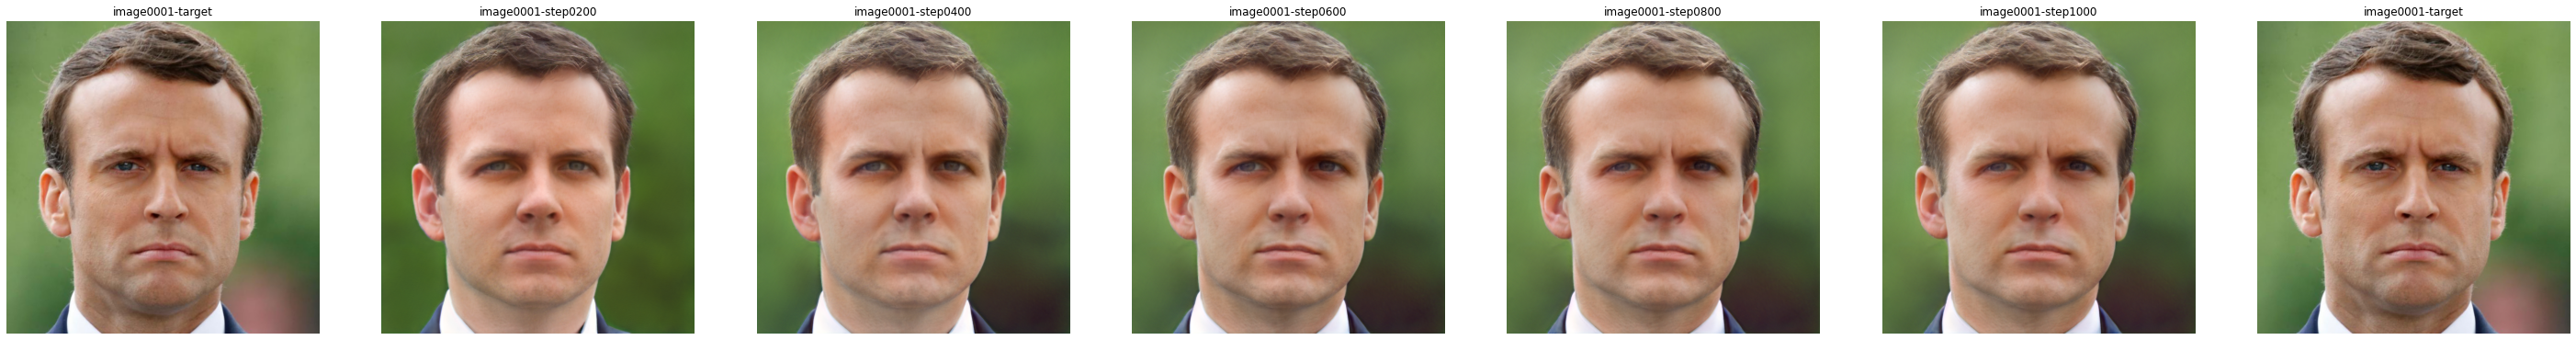

In [0]:
display_projection(image_id_as_int=1)

#### Export results

In [0]:
!tar -cvf results.tar.gz results/

results/
results/00001-project-real-images/
results/00001-project-real-images/image0000-step0280.png
results/00001-project-real-images/image0001-step0170.png
results/00001-project-real-images/image0001-step0120.png
results/00001-project-real-images/image0000-step0650.png
results/00001-project-real-images/image0001-step0500.png
results/00001-project-real-images/image0001-step0880.png
results/00001-project-real-images/image0000-step0170.png
results/00001-project-real-images/image0000-step0520.png
results/00001-project-real-images/image0001-step0280.png
results/00001-project-real-images/image0000-step0080.png
results/00001-project-real-images/image0000-step0790.png
results/00001-project-real-images/image0001-step0250.png
results/00001-project-real-images/image0001-step0150.png
results/00001-project-real-images/image0001-step0650.png
results/00001-project-real-images/image0000-step0190.png
results/00001-project-real-images/image0001-step0180.png
results/00001-project-real-images/image0001-

## Export results as videos

References:
-   https://www.gwern.net/Faces#interpolations
-   https://www.gwern.net/Faces#reversing-stylegan-to-control-modify-images
-   https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH

### Utility functions

Reference: https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

Tensorflow version: 1.15.0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-cb593904-f311-2373-3001-a14aa79e2ad9)
GPU Identified at: /device:GPU:0


In [0]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


In [0]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


### Create a video of the projection procedure

#### Increase the number of snapshots to have a smoother video.

In [0]:
!python run_projector.py project-real-images \
  --data-dir='/content/datasets' --dataset=real \
  --num-images=2 \
  --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \  
  --num-snapshots=1000 \


Local submit - run_dir: results/00001-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from "real"...
tcmalloc: large alloc 4294967296 bytes == 0x59eda000 @  0x7f1ffa5ab001 0x7f1ff80cf765 0x7f1ff8133dc0 0x7f1ff8135c5f 0x7f1ff81cc238 0x50ac25 0x50d390 0x508245 0x509642 0x595311 0x54a6ff 0x551b81 0x5a067e 0x50d966 0x508245 0x50a080 0x50aa7d 0x50d390 0x508245 0x58958c 0x5a067e 0x50d966 0x509d48 0x50aa7d 0x50c5b9 0x509d48 0x50aa7d 0x50c5b9 0x508245 0x58958c 0x5a067e
tcmalloc: large alloc 4294967296 bytes == 0x7f1db4000000 @  0x7f1ffa5a91e7 0x7f1ff80cf5e1 0x7f1ff8133e88 0x7f1ff8134147 0x7f1ff81cc118 0x50ac25 0x50d390 0x508245 0x50a080 0x50aa7d 0x50d390 0x508245 0x50a080 0x50aa7d 0x50d390 0x508245 0x50a080 0

#### Create the video

In [0]:
results_folder_path = "/content/stylegan2/results/00001-project-real-images/"

ext = '.png'

In [0]:
image_id_as_int = 1

image_id = '{:04d}'.format(image_id_as_int)
image_root_name = "image" + image_id

In [0]:
# Create video 
# Reference: https://colab.research.google.com/drive/1ShgW6wohEFQtqs_znMna3dzrcVoABKIH#scrollTo=4_s8h-ilzHQc

import glob

imgs_regex = results_folder_path+image_root_name+"-step[0-9]*"+ext
imgs = sorted(glob.glob(imgs_regex))

target_imgs_regex = results_folder_path+image_root_name+"-target"+ext
target_imgs = sorted(glob.glob(target_imgs_regex))

assert len(target_imgs) == 1, "More than one target found?"
target_img = imageio.imread(target_imgs[0])

movieName = "movie{}.mp4".format(image_id)
with imageio.get_writer(movieName, mode='I') as writer:
    for filename in log_progress(imgs, name = "Creating animation"):
        image = imageio.imread(filename)

        # Concatenate images with original target image
        w,h = image.shape[0:2]
        canvas = PIL.Image.new('RGBA', (w*2,h), 'white')
        canvas.paste(Image.fromarray(target_img), (0, 0))
        canvas.paste(Image.fromarray(image), (w, 0))

        writer.append_data(np.array(canvas))  

### Extract latent vectors

TODO

In [0]:
# # Convert uploaded images to TFRecords
# import dataset_tool
# dataset_tool.create_from_images("./projection/records/", "./projection/imgs/", True)

# Run the projector
import run_projector
import projector
import training.dataset
import training.misc
import os 

import argparse
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import re
import sys

import projector
import pretrained_networks
from training import dataset
from training import misc

# Reference: project_image() in https://github.com/NVlabs/stylegan2/blob/master/run_projector.py
def project_image_and_return_variables(proj, targets, png_prefix, num_snapshots):
    snapshot_steps = set(proj.num_steps - np.linspace(0, proj.num_steps, num_snapshots, endpoint=False, dtype=int))
    misc.save_image_grid(targets, png_prefix + 'target.png', drange=[-1,1])
    proj.start(targets)
    while proj.get_cur_step() < proj.num_steps:
        print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
        proj.step()
        if proj.get_cur_step() in snapshot_steps:
            misc.save_image_grid(proj.get_images(), png_prefix + 'step%04d.png' % proj.get_cur_step(), drange=[-1,1])
    print('\r%-30s\r' % '', end='', flush=True)

    variables = dict()
    variables['dlatents'] = proj.get_dlatents()
    variables['noises'] = proj.get_noises()
    variables['images'] = proj.get_images()

    return variables

def project_real_images(dataset_name,
                        data_dir, 
                        num_images, 
                        num_snapshots):
    result_root_dir='results/'
    result_dir = result_root_dir + '99991-project-real-images/'
    %mkdir -p 'results/99991-project-real-images/'

    proj = projector.Projector()
    proj.set_network(Gs)

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = training.dataset.load_dataset(data_dir=data_dir,
                                                tfrecord_dir=dataset_name,
                                                max_label_size=0, 
                                                verbose=True, 
                                                repeat=False, 
                                                shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]   

    variables_dict = dict()

    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))        
        output_file_name_prefix = result_dir + 'image{:04d}-'.format(image_idx)

        images, _labels = dataset_obj.get_minibatch_np(1)
        images = training.misc.adjust_dynamic_range(images, 
                                                    [0, 255], 
                                                    [-1, 1])
        
        variables = project_image_and_return_variables(proj, 
                                           targets=images, 
                                           png_prefix=dnnlib.make_run_dir_path(output_file_name_prefix),
                                           num_snapshots=num_snapshots)

        variables_dict[image_idx] = variables

    return variables_dict

ModuleNotFoundError: ignored

In [0]:
variables_dict = project_real_images('real',
                    '/content/datasets',
                    2,
                    5)

### Create videos of the interpolation

TODO

In [0]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289 , 9148088 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.4 , 3))

In [0]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613])

number_of_steps = 10
imgs = generate_images(interpolate(zs,number_of_steps), 1.0)

# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

In [0]:
# more complex example, interpolating in W instead of Z space.
zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613 ])

# It seems my truncation_psi is slightly less efficient in W space - I probably introduced an error somewhere...

dls = []
for z in zs:
  dls.append(convertZtoW(z ,truncation_psi=1.0))

number_of_steps = 100

imgs = generate_images_in_w_space(interpolate(dls,number_of_steps), 1.0)

%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))